Import required packages

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy import distance
import folium
import requests
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Import Foursquare credentials from json file created to preserve secrecy and store in global variables CLIENT_ID and CLIENT_SECRET

In [2]:
import json
globals().update(json.loads(open("foursquareCredentials.json", "r") .read()))
VERSION = '20181124' # Foursquare API version

## Input the variables that define the problem
Get longitude and latitude of location where we want to open a new business

In [3]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
#location = geolocator.geocode("Budapest Hungary")
#location = geolocator.geocode("Toronto")
location = geolocator.geocode("canterbury uk")
lat = location.latitude
long = location.longitude
location

Location(Canterbury, Kent, South East, England, UK, (51.2800275, 1.0802533, 0.0))

Populate variables containing the other parameters of the search problem:
* categoryId = foursquare categoryId of the business we wish to open. A full list of categories can be found here: https://developer.foursquare.com/docs/resources/categories.
* radius = the maximum distance from the location within which we want to open the business in km.
* tick = the level of accuracy in km which we want to return for the recommended locations. 

In [4]:
categoryId = '4bf58dd8d48988d16d941735' # Café
radius = 2
tick = 0.1

## Build grid of points within radius of location
Define function degreeLen which for a given lat and long returns the length of a degree of lat and long in km

In [5]:
def degreeLen(lat, long):
    """Returns the lengths of a single degree of latitude and longitude in km for a given latitude and longitude
    """
    # get length of 1 degree at current latidude and logitude
    latDegree = distance.distance((lat - 0.5, long), (lat + 0.5, long)).km
    longDegree = distance.distance((lat, long - 0.5), (lat, long + 0.5)).km
    return latDegree, longDegree
degreeLen(lat, long)

(111.25362764404056, 69.77374794257956)

Define function grid that returns the set of grid points within a circle around location.  Grid points are a distance tick apart.

In [6]:
def grid(lat, long, radius, tick):
    """Returns a set whose elements are a grid of points within a circle around a location
    :param lat: latitude of centre of grid
    :param long: longitude of centre of grid
    :param radius: radius of grid in km
    :param tick: distance between points in grid in km
    """
    # get length of 1 degree at current latidude and logitude
    latDegree, longDegree = degreeLen(lat, long)
    
    # get length of 1 tick in degrees
    latTick = tick / latDegree
    longTick = tick / longDegree
    
    # get coordinates of point which is one radius to the South and West of (lat, long)
    bottomLeft = (lat - radius / latDegree, long - radius / longDegree)
    
    # get tick points along axis
    gridLats = np.arange(2 * radius / tick + 1) * latTick + bottomLeft[0]
    gridLongs = np.arange(2 * radius / tick + 1) * longTick + bottomLeft[1]
    
    # create the set grid made up of points within radius of lat, long, disance tick apart 
    grid = {(lt, lg) for lt in gridLats for lg in gridLongs if distance.distance((lat, long), (lt, lg)).km <= radius}
    
    return grid

Check grid function is working using Folium

In [7]:
g = grid(lat, long, radius, tick)
print("Number of points in grid = " + str(len(g)))
# create map
map_grid = folium.Map(location=[lat, long])
minLat = lat
maxLat = long
minLong = lat
maxLong = long
for (lt, lg) in g:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=0.5).add_to(map_grid)
    if lt < minLat:
        minLat = lt
    if lt > maxLat:
        maxLat = lt
    if lg < minLong:
        minLong = lg
    if lg > maxLong:
        maxLong = lg
latDegree, longDegree = degreeLen(lat, long)
minLat = minLat - tick / latDegree
maxLat = maxLat + tick / latDegree
minLong = minLong - tick / longDegree
maxLong = maxLong + tick / longDegree
map_grid.fit_bounds([[minLat, minLong], [maxLat, maxLong]])    
folium.features.RectangleMarker([[minLat, minLong],[minLat, maxLong], [maxLat, maxLong], [maxLat, minLong]], fill_opacity=0.0).add_to(map_grid)
map_grid

Number of points in grid = 1250


## Build function which pulls venue data from Foursquare
Define function for pulling list of nearby venues, with optional filter on category Id

In [8]:
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=browse&ll={},{}&radius={}&categoryId={}'
def getNearbyVenues(lat, long, radius, categoryId = ''):
    apiCall = url.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, radius, categoryId)
    venues = requests.get(apiCall).json()['response']['venues']
    venues_list=[]
    
    for v in venues:
        if len(v['categories']) > 0:
            venues_list.append([v['id'], v['name'], v['location']['lat'], v['location']['lng'],
                                v['location']['distance'], v['categories'][0]['name']])
        else:
            venues_list.append([v['id'], v['name'], v['location']['lat'], v['location']['lng'],
                                v['location']['distance'], 'None'])
    
    return(venues_list)

Check function getNearbyVenues is working

In [9]:
getNearbyVenues(lat, long, tick * 1000, categoryId)

[['4fc8b489e4b00f559926d98e',
  'Chocolate Cafe',
  51.279911067726225,
  1.0806316876310738,
  29,
  'Café'],
 ['4c2b2e232219c928c81ea448',
  'Chambers Café',
  51.28001030496828,
  1.0807589751977684,
  35,
  'American Restaurant'],
 ['4d2b25428e102c0f0b71d16e',
  'Canteen',
  51.279449576787584,
  1.0809777699989296,
  81,
  'Café'],
 ['5b34cd47a795bd0039580cb7', 'Eleto Café', 51.279869, 1.080935, 50, 'Café'],
 ['4c7e5156d598a0934e57c562',
  'Venezia',
  51.27994072549095,
  1.080774501921988,
  37,
  'Italian Restaurant'],
 ['5426d39b498e259fb70fab27',
  'Roast & Ground',
  51.279836,
  1.080584,
  31,
  'Café']]

## Build function to calculate density of venues within a specified radius of a location
Define function venueDensity which outputs a measure the density of a list of venues within a specific radius of a location.
The density measure has the property of being larger the more venues there are in the list and the closer they are.
So for each venue we subtract the distance of the venue from the location from the radius.
This measure is then summed up for all the venues

Worked example, radius = 200m, 2 venues, 1 distance 1m from the location, the other distance 199m:
* venue 1 density = 200 - 1 = 199
* venue 2 density = 200 - 199 = 1
* total density = 199 + 1 = 200

In [10]:
def venueDensity(venues, radius):
    distances = []
    [distances.append(radius - v[4]) for v in venues if v[4] < radius]
    return np.sum(np.asarray(distances))

In [11]:
venueDensity(getNearbyVenues(lat, long, tick * 1000, categoryId), tick * 1000)

337.0

In [12]:
# Check if density for empty list of venues = 0
venueDensity([], tick * 1000)

0.0

## Get venue density for each point on the grid around location

In [13]:
densities = []
targetVenues = set()
ids = set()
total = len(g)
i = 0
for (lt, lg) in g:
    i+=1
    print("Getting venues for point " + str(i) + ' of ' + str(total))
    venues = getNearbyVenues(lt, lg, tick * 1000, categoryId)
    density = venueDensity(venues, tick * 1000)
    densities.append((lt, lg, density))
    for (v_id, name, vlt, vlg, distance, category) in venues:
        ids.add(v_id)
        targetVenues.add((v_id, name, vlt, vlg))

Getting venues for point 1 of 1250
Getting venues for point 2 of 1250
Getting venues for point 3 of 1250
Getting venues for point 4 of 1250
Getting venues for point 5 of 1250
Getting venues for point 6 of 1250
Getting venues for point 7 of 1250
Getting venues for point 8 of 1250
Getting venues for point 9 of 1250
Getting venues for point 10 of 1250
Getting venues for point 11 of 1250
Getting venues for point 12 of 1250
Getting venues for point 13 of 1250
Getting venues for point 14 of 1250
Getting venues for point 15 of 1250
Getting venues for point 16 of 1250
Getting venues for point 17 of 1250
Getting venues for point 18 of 1250
Getting venues for point 19 of 1250
Getting venues for point 20 of 1250
Getting venues for point 21 of 1250
Getting venues for point 22 of 1250
Getting venues for point 23 of 1250
Getting venues for point 24 of 1250
Getting venues for point 25 of 1250
Getting venues for point 26 of 1250
Getting venues for point 27 of 1250
Getting venues for point 28 of 1250
G

Getting venues for point 226 of 1250
Getting venues for point 227 of 1250
Getting venues for point 228 of 1250
Getting venues for point 229 of 1250
Getting venues for point 230 of 1250
Getting venues for point 231 of 1250
Getting venues for point 232 of 1250
Getting venues for point 233 of 1250
Getting venues for point 234 of 1250
Getting venues for point 235 of 1250
Getting venues for point 236 of 1250
Getting venues for point 237 of 1250
Getting venues for point 238 of 1250
Getting venues for point 239 of 1250
Getting venues for point 240 of 1250
Getting venues for point 241 of 1250
Getting venues for point 242 of 1250
Getting venues for point 243 of 1250
Getting venues for point 244 of 1250
Getting venues for point 245 of 1250
Getting venues for point 246 of 1250
Getting venues for point 247 of 1250
Getting venues for point 248 of 1250
Getting venues for point 249 of 1250
Getting venues for point 250 of 1250
Getting venues for point 251 of 1250
Getting venues for point 252 of 1250
G

Getting venues for point 449 of 1250
Getting venues for point 450 of 1250
Getting venues for point 451 of 1250
Getting venues for point 452 of 1250
Getting venues for point 453 of 1250
Getting venues for point 454 of 1250
Getting venues for point 455 of 1250
Getting venues for point 456 of 1250
Getting venues for point 457 of 1250
Getting venues for point 458 of 1250
Getting venues for point 459 of 1250
Getting venues for point 460 of 1250
Getting venues for point 461 of 1250
Getting venues for point 462 of 1250
Getting venues for point 463 of 1250
Getting venues for point 464 of 1250
Getting venues for point 465 of 1250
Getting venues for point 466 of 1250
Getting venues for point 467 of 1250
Getting venues for point 468 of 1250
Getting venues for point 469 of 1250
Getting venues for point 470 of 1250
Getting venues for point 471 of 1250
Getting venues for point 472 of 1250
Getting venues for point 473 of 1250
Getting venues for point 474 of 1250
Getting venues for point 475 of 1250
G

Getting venues for point 671 of 1250
Getting venues for point 672 of 1250
Getting venues for point 673 of 1250
Getting venues for point 674 of 1250
Getting venues for point 675 of 1250
Getting venues for point 676 of 1250
Getting venues for point 677 of 1250
Getting venues for point 678 of 1250
Getting venues for point 679 of 1250
Getting venues for point 680 of 1250
Getting venues for point 681 of 1250
Getting venues for point 682 of 1250
Getting venues for point 683 of 1250
Getting venues for point 684 of 1250
Getting venues for point 685 of 1250
Getting venues for point 686 of 1250
Getting venues for point 687 of 1250
Getting venues for point 688 of 1250
Getting venues for point 689 of 1250
Getting venues for point 690 of 1250
Getting venues for point 691 of 1250
Getting venues for point 692 of 1250
Getting venues for point 693 of 1250
Getting venues for point 694 of 1250
Getting venues for point 695 of 1250
Getting venues for point 696 of 1250
Getting venues for point 697 of 1250
G

Getting venues for point 893 of 1250
Getting venues for point 894 of 1250
Getting venues for point 895 of 1250
Getting venues for point 896 of 1250
Getting venues for point 897 of 1250
Getting venues for point 898 of 1250
Getting venues for point 899 of 1250
Getting venues for point 900 of 1250
Getting venues for point 901 of 1250
Getting venues for point 902 of 1250
Getting venues for point 903 of 1250
Getting venues for point 904 of 1250
Getting venues for point 905 of 1250
Getting venues for point 906 of 1250
Getting venues for point 907 of 1250
Getting venues for point 908 of 1250
Getting venues for point 909 of 1250
Getting venues for point 910 of 1250
Getting venues for point 911 of 1250
Getting venues for point 912 of 1250
Getting venues for point 913 of 1250
Getting venues for point 914 of 1250
Getting venues for point 915 of 1250
Getting venues for point 916 of 1250
Getting venues for point 917 of 1250
Getting venues for point 918 of 1250
Getting venues for point 919 of 1250
G

Getting venues for point 1112 of 1250
Getting venues for point 1113 of 1250
Getting venues for point 1114 of 1250
Getting venues for point 1115 of 1250
Getting venues for point 1116 of 1250
Getting venues for point 1117 of 1250
Getting venues for point 1118 of 1250
Getting venues for point 1119 of 1250
Getting venues for point 1120 of 1250
Getting venues for point 1121 of 1250
Getting venues for point 1122 of 1250
Getting venues for point 1123 of 1250
Getting venues for point 1124 of 1250
Getting venues for point 1125 of 1250
Getting venues for point 1126 of 1250
Getting venues for point 1127 of 1250
Getting venues for point 1128 of 1250
Getting venues for point 1129 of 1250
Getting venues for point 1130 of 1250
Getting venues for point 1131 of 1250
Getting venues for point 1132 of 1250
Getting venues for point 1133 of 1250
Getting venues for point 1134 of 1250
Getting venues for point 1135 of 1250
Getting venues for point 1136 of 1250
Getting venues for point 1137 of 1250
Getting venu

In [14]:
print("Number of venues = " + str(len(targetVenues)))
# create map
m = folium.Map(location=[lat, long], zoom_start=13)


for (v_id, name, vlt, vlg) in targetVenues:
    folium.CircleMarker([vlt, vlg],
                        color='black',
                        radius=0.1,
                        fill=False).add_to(m)      
m

Number of venues = 47


In [15]:
densitiesDf = pd.DataFrame(densities)
densitiesDf.columns = ['Latitude', 'Longitude', 'Density']
densitiesDf.set_index(['Latitude', 'Longitude'], inplace=True)
densitiesDf.sort_index(inplace=True)
densitiesDf

Density
Latitude  Longitude         
51.262051 1.080253       0.0
51.262949 1.071654       0.0
          1.073087       0.0
          1.074520       0.0
          1.075954       0.0
          1.077387       0.0
          1.078820       0.0
          1.080253       0.0
          1.081687       0.0
          1.083120       0.0
          1.084553       0.0
          1.085986       0.0
          1.087419       0.0
          1.088853       0.0
51.263848 1.068788       0.0
          1.070221       0.0
          1.071654       0.0
          1.073087       0.0
          1.074520       0.0
          1.075954       0.0
          1.077387       0.0
          1.078820       0.0
          1.080253       0.0
          1.081687       0.0
          1.083120       0.0
          1.084553       0.0
          1.085986       0.0
          1.087419       0.0
          1.088853       0.0
          1.090286       0.0
...                      ...
51.296207 1.068788       0.0
          1.070221       0.0
          1.071654       0.0
          1.073087       0.0
          1.074520       0.0
          1.075954       0.0
          1.077387       0.0
          1.078820       0.0
          1.080253       0.0
          1.081687       0.0
          1.083120       0.0
          1.084553       0.0
          1.085986       0.0
          1.087419       0.0
          1.088853       0.0
          1.090286       0.0
          1.091719       0.0
51.297106 1.071654       0.0
          1.073087       0.0
          1.074520       0.0
          1.075954       0.0
          1.077387       0.0
          1.078820       0.0
          1.080253       0.0
          1.081687       0.0
          1.083120       0.0
          1.084553       0.0
          1.085986       0.0
          1.087419       0.0
          1.088853       0.0

[1250 rows x 1 columns]

In [16]:
max_density = densitiesDf.max()
max_density

Density    337.0
dtype: float64

In [17]:

m = folium.Map(location=[lat, long], zoom_start=13)
for (lt, lg, density) in densities:
    opacity = density / max_density
    bottomLeft = [lt - tick / latDegree / 2, lg - tick / longDegree / 2]
    bottomRight = [lt - tick / latDegree / 2, lg + tick / longDegree / 2]
    topRight = [lt + tick / latDegree / 2, lg + tick / longDegree / 2]
    topLeft = [lt + tick / latDegree / 2, lg - tick / longDegree / 2]
    bounds = [bottomLeft, bottomRight, topRight, topLeft]
    folium.features.RectangleMarker(bounds, weight=0, fill_color='red', fill_opacity=float(opacity)).add_to(m) 
    



for (v_id, name, vlt, vlg) in targetVenues:
    folium.CircleMarker([vlt, vlg],
                        color='black',
                        radius=0.1,
                        fill=False).add_to(m)      
m

In [18]:
densitiesDf.describe()

,Density
count,1250.000000
mean,3.998400
std,21.116134
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,337.000000


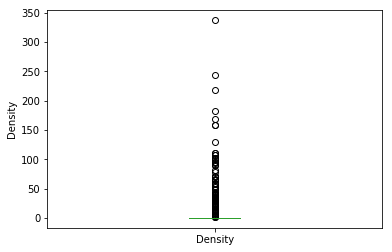

In [19]:
densitiesDf.plot(y='Density', kind='box')
plt.ylabel('Density')
plt.show()

In [20]:
densitiesDf['Log Density'] = np.log10(densitiesDf['Density'].values + 1)

In [21]:
densitiesDf.describe()

,Density,Log Density
count,1250.000000,1250.000000
mean,3.998400,0.109066
std,21.116134,0.416024
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,337.000000,2.528917


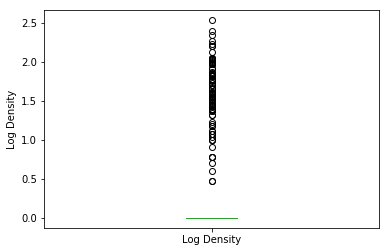

In [22]:
densitiesDf.plot(y='Log Density', kind='box')
plt.ylabel('Log Density')
plt.show()

In [23]:
ids

{'4b9faacbf964a520213337e3',
 '4bb34b1f35f0c9b6bb29bc83',
 '4bbeff6af353d13ae2e87d10',
 '4bdc8b30afe8c9b61fec4f85',
 '4be36a92fe2995218b94966c',
 '4bee71f33686c9b68684246e',
 '4c2b2e232219c928c81ea448',
 '4c3dd8b0ea36ef3b92517285',
 '4c3efad11ef0d13ac4fb9280',
 '4c5a9fb0f54376b076ca848b',
 '4c7e5156d598a0934e57c562',
 '4c83742551ada1cd38ea2510',
 '4c84e21fdc018cfabcd7e36c',
 '4c99b19f78fc236a01282f97',
 '4ca74f4f44a8224b89b40b40',
 '4cb08643aef16dcbe974b154',
 '4cb99428dd41a35dce69e2a0',
 '4ccfdd640d9b952182868ea3',
 '4cf90a7ede096dcb13198c79',
 '4cfa1136c671721e073dbb18',
 '4d0b8db8984a6ea881279264',
 '4d2b25428e102c0f0b71d16e',
 '4e3e9970e4cdab9b93522c8d',
 '4e6b2e6852b1c1206022b89e',
 '4ecfad9c8b81b473959befc2',
 '4f130abfe4b0958ec2d8b175',
 '4f5b89d6e4b0a61f4b2e17a5',
 '4fc8b489e4b00f559926d98e',
 '50506fb8e4b0361aabb39d57',
 '510a662ce4b090e4573ea18f',
 '51613e0fe4b0b6b8523f4c67',
 '5248345d11d2b80241bc1075',
 '525aa2c811d2975bc4760772',
 '53205847498e26061085c708',
 '5426d39b498e

In [ ]:
i = 0
otherVenues = []
for (lt, lg) in g:
    i+=1
    print("Getting venues for point " + str(i) + ' of ' + str(total))
    venues = getNearbyVenues(lt, lg, tick * 1000)
    for (v_id, name, vlt, vlg, distance, category) in venues:
        if not (v_id in ids) and category != 'None' and distance < tick * 1000 :
            otherVenues.append((lt, lg, v_id, name, vlt, vlg, distance, category))

Getting venues for point 1 of 1250
Getting venues for point 2 of 1250
Getting venues for point 3 of 1250
Getting venues for point 4 of 1250
Getting venues for point 5 of 1250
Getting venues for point 6 of 1250
Getting venues for point 7 of 1250
Getting venues for point 8 of 1250
Getting venues for point 9 of 1250
Getting venues for point 10 of 1250
Getting venues for point 11 of 1250
Getting venues for point 12 of 1250
Getting venues for point 13 of 1250
Getting venues for point 14 of 1250
Getting venues for point 15 of 1250
Getting venues for point 16 of 1250
Getting venues for point 17 of 1250
Getting venues for point 18 of 1250
Getting venues for point 19 of 1250
Getting venues for point 20 of 1250
Getting venues for point 21 of 1250
Getting venues for point 22 of 1250
Getting venues for point 23 of 1250
Getting venues for point 24 of 1250
Getting venues for point 25 of 1250
Getting venues for point 26 of 1250
Getting venues for point 27 of 1250
Getting venues for point 28 of 1250
G

Getting venues for point 226 of 1250
Getting venues for point 227 of 1250
Getting venues for point 228 of 1250
Getting venues for point 229 of 1250
Getting venues for point 230 of 1250
Getting venues for point 231 of 1250
Getting venues for point 232 of 1250
Getting venues for point 233 of 1250
Getting venues for point 234 of 1250
Getting venues for point 235 of 1250
Getting venues for point 236 of 1250
Getting venues for point 237 of 1250
Getting venues for point 238 of 1250
Getting venues for point 239 of 1250
Getting venues for point 240 of 1250
Getting venues for point 241 of 1250
Getting venues for point 242 of 1250
Getting venues for point 243 of 1250
Getting venues for point 244 of 1250
Getting venues for point 245 of 1250
Getting venues for point 246 of 1250
Getting venues for point 247 of 1250
Getting venues for point 248 of 1250
Getting venues for point 249 of 1250
Getting venues for point 250 of 1250
Getting venues for point 251 of 1250
Getting venues for point 252 of 1250
G

Getting venues for point 449 of 1250
Getting venues for point 450 of 1250
Getting venues for point 451 of 1250
Getting venues for point 452 of 1250
Getting venues for point 453 of 1250
Getting venues for point 454 of 1250
Getting venues for point 455 of 1250
Getting venues for point 456 of 1250
Getting venues for point 457 of 1250
Getting venues for point 458 of 1250
Getting venues for point 459 of 1250
Getting venues for point 460 of 1250
Getting venues for point 461 of 1250
Getting venues for point 462 of 1250
Getting venues for point 463 of 1250
Getting venues for point 464 of 1250
Getting venues for point 465 of 1250
Getting venues for point 466 of 1250
Getting venues for point 467 of 1250
Getting venues for point 468 of 1250
Getting venues for point 469 of 1250
Getting venues for point 470 of 1250
Getting venues for point 471 of 1250
Getting venues for point 472 of 1250
Getting venues for point 473 of 1250
Getting venues for point 474 of 1250
Getting venues for point 475 of 1250
G

Getting venues for point 671 of 1250
Getting venues for point 672 of 1250
Getting venues for point 673 of 1250
Getting venues for point 674 of 1250
Getting venues for point 675 of 1250
Getting venues for point 676 of 1250
Getting venues for point 677 of 1250
Getting venues for point 678 of 1250
Getting venues for point 679 of 1250
Getting venues for point 680 of 1250
Getting venues for point 681 of 1250
Getting venues for point 682 of 1250
Getting venues for point 683 of 1250
Getting venues for point 684 of 1250
Getting venues for point 685 of 1250
Getting venues for point 686 of 1250
Getting venues for point 687 of 1250
Getting venues for point 688 of 1250
Getting venues for point 689 of 1250
Getting venues for point 690 of 1250
Getting venues for point 691 of 1250
Getting venues for point 692 of 1250
Getting venues for point 693 of 1250
Getting venues for point 694 of 1250
Getting venues for point 695 of 1250
Getting venues for point 696 of 1250
Getting venues for point 697 of 1250
G

In [ ]:
otherVenuesDf = pd.DataFrame(otherVenues)
otherVenuesDf.columns = ['Latitude', 'Longitude', 'VenueID', 'Name', 'VenueLat', 'VenueLong', 'Distance', 'Category']
otherVenuesDf.set_index(['Latitude', 'Longitude'], inplace=True)
otherVenuesDf.sort_index(inplace=True)
otherVenuesDf

In [ ]:
otherVenuesDf['Density'] = (tick * 1000) - otherVenuesDf['Distance']
otherVenuesDf

In [ ]:
features = pd.pivot_table(otherVenuesDf,index=['Latitude', 'Longitude'],values='Density',
                          columns='Category',aggfunc=[np.sum],fill_value=0)['sum']

In [ ]:
features.info()

In [ ]:
features

In [ ]:
features.describe()

In [ ]:
features = np.log10(features + 1)

In [ ]:
features.describe()

In [ ]:
features = features.join(densitiesDf).fillna(0).reset_index()

In [ ]:
features.describe()

In [ ]:
X = features.drop(['Latitude', 'Longitude', 'Density', 'Log Density'], axis=1)
y = features['Log Density']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=22)

In [ ]:
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
y_pred_test = reg_all.predict(X_test)
y_pred_train = reg_all.predict(X_train)
reg_all.score(X_test, y_test)

In [ ]:
testDf = y_test.to_frame()
testDf['Predicted'] = y_pred_test
testDf.plot(kind='box')
plt.show()

In [ ]:
testDf.describe()

In [ ]:
plt.scatter(y_test, y_pred_test, color='blue', label='Test')
plt.scatter(y_train, y_pred_train, color='red', label='Training')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

In [ ]:
lasso = linear_model.Lasso(alpha=0.005, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred_test = lasso.predict(X_test)
lasso_pred_train = lasso.predict(X_train)
lasso.score(X_test, y_test)

In [ ]:
testDf = y_test.to_frame()
testDf['Predicted'] = lasso_pred_test
testDf.plot(kind='box')
plt.show()

In [ ]:
plt.scatter(y_test, lasso_pred_test, color='blue', label='Test')
plt.scatter(y_train, lasso_pred_train, color='red', label='Training')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

In [ ]:
lasso_pred_all = lasso.predict(X)

In [ ]:
plt.scatter(y, lasso_pred_all, color='green')
plt.show()

In [ ]:
len(lasso_pred_all)

In [ ]:
results = features[['Latitude', 'Longitude', 'Log Density']]

In [ ]:
results['Predicted'] = lasso_pred_all

In [ ]:
plt.scatter(results['Log Density'], results['Predicted'], color='green')
plt.show()

In [ ]:
results['Rank'] = results['Predicted'] / (results['Log Density'] + 1)

In [ ]:
top10 = results.sort_values(by='Rank', ascending=False).head(10)
top10

In [ ]:
l = list(zip(top10['Latitude'], top10['Longitude']))
l

In [ ]:
# create map

for (lt, lg) in l:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=1,
                        color='Blue').add_to(m)
       
m